In [306]:
import torch
import torch.nn as nn
import torch.optim as optim

import re

import random

from math import inf

import tqdm
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [307]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()
plt.figure(figsize=(14, 14))

<Figure size 1400x1400 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1400x1400 with 0 Axes>

In [308]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [309]:
class Dictionary():
    def __init__(self, name):
        self.name = name
        self.word2idx = {'<sos>': 0, '<eos>': 1, '<unk>': 2}
        self.word2count = {'<sos>': 1, '<eos>': 1, '<unk>': 1}
        self.idx2word = {0: '<sos>', 1: '<eos>', 2: '<unk>'}
        self.num_words = 3
        
    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWord(word)
        
    def addWord(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.num_words
            self.word2count[word] = 1
            self.idx2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    def __len__(self):
        return self.num_words

In [310]:
class Corpus():
    def __init__(self, source_name, target_name):
        self.source_lang = Dictionary(source_name)
        self.target_lang = Dictionary(target_name)
    
    def get_data(self, path, MAX_LENGTH=10):
        pairs = []

        with open(path, 'r') as lines:
            for line in lines:
                pair = line.replace('\n', '').split(',')
                if (len(pair[0].split()) <= MAX_LENGTH and 
                        len(pair[1].split()) <= MAX_LENGTH and 
                            len(pair[0].split()) > 2 and len(pair[1].split()) > 2):
                    pairs.append(pair)
                    self.source_lang.addSentence(pair[0])
                    self.target_lang.addSentence(pair[1])

        return pairs, self.source_lang, self.target_lang
    
corpus = Corpus('en', 'de')
pairs, source_lang, target_lang = corpus.get_data('en-de_corpus.txt',
                                                  MAX_LENGTH=10)
random.choice(pairs)

['<sos> a nurse is taking care of a patient <eos>',
 '<sos> eine krankenschwester kummert sich um einen patienten <eos>']

In [311]:
LEN_SOURCE_VOCAB = source_lang.num_words
LEN_TARGET_VOCAB = target_lang.num_words
LEN_SOURCE_VOCAB, LEN_TARGET_VOCAB

(3045, 3931)

In [312]:
print(f"Unique tokens in source (en) vocabulary: {LEN_SOURCE_VOCAB}")
print(f"Unique tokens in target (de) vocabulary: {LEN_TARGET_VOCAB}")

Unique tokens in source (en) vocabulary: 3045
Unique tokens in target (de) vocabulary: 3931


In [313]:
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
N_LAYERS = 1
DROPOUT = 0.5

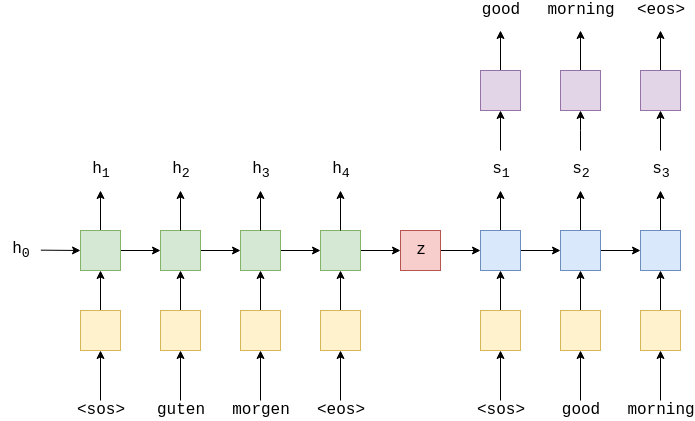

In [314]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers, dropout):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size,
                                      embedding_size)
        
        self.rnn = nn.GRU(embedding_size,
                           hidden_size,
                           n_layers,
                           dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, hidden):
        embed = self.dropout(self.embedding(source))
        
        output, hidden = self.rnn(embed, hidden)

        return hidden

encoder = Encoder(LEN_SOURCE_VOCAB,
                  EMBEDDING_SIZE,
                  HIDDEN_SIZE,
                  N_LAYERS,
                  DROPOUT)

In [315]:
class Decoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, n_layers, dropout):
        super().__init__()

        self.output_size = output_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_size,
                                      embedding_size)
        
        self.rnn = nn.GRU(embedding_size,
                           hidden_size,
                           n_layers,
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_size,
                             output_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
    
        embed = self.dropout(self.embedding(input))
        
        output, hidden = self.rnn(embed, hidden)

        prediction = self.fc1(output)

        return prediction, hidden

decoder = Decoder(LEN_TARGET_VOCAB,
                  EMBEDDING_SIZE,
                  HIDDEN_SIZE,
                  N_LAYERS,
                  DROPOUT)

In [316]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        encoder_hidden = torch.zeros((self.encoder.n_layers, 1, self.encoder.hidden_size)).to(device)
  
        for ei in range(len(source)):
            encoder_hidden = self.encoder(source[ei].unsqueeze(1), 
                                          encoder_hidden)

        target_word = target[0].unsqueeze(1)

        outputs = torch.zeros(len(target) - 1, self.decoder.output_size).to(device)

        decoder_hidden = encoder_hidden
        
        for di in range(0, len(target) - 1):
            decoder_output, decoder_hidden = self.decoder.forward(target_word, decoder_hidden)

            outputs[di] = decoder_output

            teacher_force = random.random() < teacher_forcing_ratio

            prediction = torch.tensor([decoder_output.argmax()]).to(device)

            target_word = target[di + 1].unsqueeze(1) if teacher_forcing_ratio else prediction.unsqueeze(1)

        return outputs

seq2seq = Seq2seq(encoder, decoder).to(device)

In [317]:
optimizer = optim.Adam(seq2seq.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [318]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.xavier_uniform_(param.data.unsqueeze_(0))
        
seq2seq.apply(init_weights)

Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(3045, 300)
    (rnn): GRU(300, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3931, 300)
    (rnn): GRU(300, 512, dropout=0.5)
    (fc1): Linear(in_features=512, out_features=3931, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [319]:
def count_parameters(model):
    return sum(p.numel() for p in seq2seq.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 6,610,011 trainable parameters


In [320]:
def pair2tensor(pair):
    source = torch.tensor([source_lang.word2idx[word] for word in pair[0].split()], dtype=torch.long)
    target = torch.tensor([target_lang.word2idx[word] for word in pair[1].split()], dtype=torch.long)

    return source.unsqueeze(1), target.unsqueeze(1)

In [321]:
data_size = len(pairs)
data_size

4195

In [322]:
max_epoch = 15
best_epoch_loss = inf

epochs = []
losses = []

for epoch in range(1, max_epoch):
    seq2seq.train()

    epoch_loss = 0
    
    for step, pair in enumerate(tqdm(pairs)):
        source, target = pair2tensor(pair)
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()

        output = seq2seq.forward(source, target, teacher_forcing_ratio=0.5)

        loss = criterion(output, target[1:].squeeze())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()

    epochs.append(epoch)
    losses.append(epoch_loss / data_size)

    print('epoch:', epoch)
    print('loss:', epoch_loss / data_size)

    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        torch.save(seq2seq.state_dict(), 'seq2seq_model.pt')

100%|██████████| 4195/4195 [01:04<00:00, 65.18it/s]


epoch: 1
loss: 4.476071206449183


100%|██████████| 4195/4195 [01:04<00:00, 65.35it/s]


epoch: 2
loss: 3.0972251057340645


100%|██████████| 4195/4195 [01:04<00:00, 64.99it/s]


epoch: 3
loss: 2.2248564099064887


100%|██████████| 4195/4195 [01:04<00:00, 64.63it/s]


epoch: 4
loss: 1.5322842244334136


100%|██████████| 4195/4195 [01:03<00:00, 65.89it/s]


epoch: 5
loss: 1.0657983128567525


100%|██████████| 4195/4195 [01:03<00:00, 66.29it/s]


epoch: 6
loss: 0.80821928849224


100%|██████████| 4195/4195 [01:04<00:00, 65.12it/s]


epoch: 7
loss: 0.6665177236455443


100%|██████████| 4195/4195 [01:03<00:00, 66.21it/s]


epoch: 8
loss: 0.5860353179701551


100%|██████████| 4195/4195 [01:03<00:00, 66.39it/s]


epoch: 9
loss: 0.5553419030970518


100%|██████████| 4195/4195 [01:03<00:00, 65.84it/s]


epoch: 10
loss: 0.5239509943205002


100%|██████████| 4195/4195 [01:03<00:00, 65.93it/s]


epoch: 11
loss: 0.5150765416232881


100%|██████████| 4195/4195 [01:03<00:00, 65.88it/s]


epoch: 12
loss: 0.5129708462215226


100%|██████████| 4195/4195 [01:03<00:00, 66.10it/s]


epoch: 13
loss: 0.48480373297389806


100%|██████████| 4195/4195 [01:04<00:00, 65.19it/s]

epoch: 14
loss: 0.48734463785738374


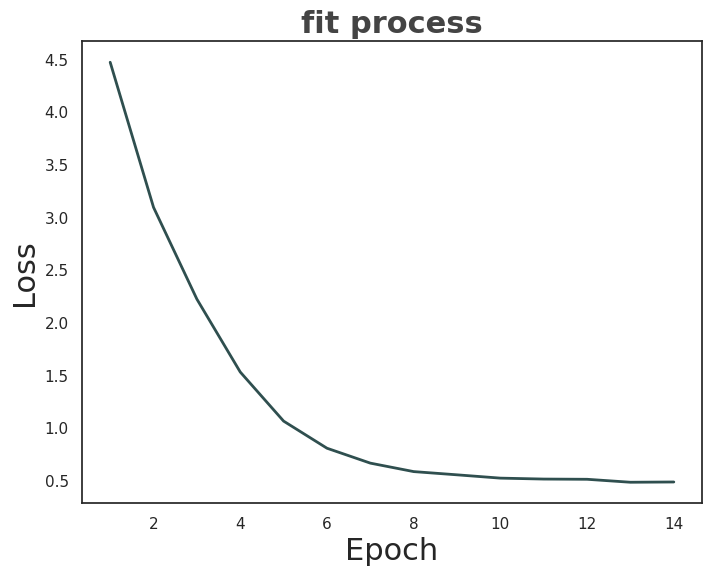

In [323]:
plt.plot(epochs, losses, color='darkslategray', linewidth=2)
plt.xlabel('Epoch', size=22)
plt.ylabel('Loss', size=22)
plt.title('fit process', size=22, y=1, 
          fontweight='bold', color='#444444')
plt.show()

In [324]:
def evaluate(model, num_samples):
    for sample in range(num_samples):
        seq2seq.eval()
        source, target = random.choice(pairs)
        print('>', source)
        print('=', target)
        source, target = pair2tensor([source, target])

        outputs = seq2seq.forward(source.to(device), target.to(device), 
                                teacher_forcing_ratio=0)
        
        predicted = ' '.join([target_lang.idx2word[word.item()] 
                            for word in outputs.argmax(1)])
        
        print('<', predicted)
        print('\n')

In [325]:
evaluate(seq2seq, num_samples=5)

> <sos> a little boy in blue doing bike jumps <eos>
= <sos> ein kleiner junge in blauer kleidung macht fahrradsprunge <eos>
< ein kleiner junge in blauer kleidung macht fahrradsprunge <eos>


> <sos> a brown dog is running through the field <eos>
= <sos> ein brauner hund rennt uber das feld <eos>
< ein brauner hund rennt uber das feld <eos>


> <sos> three thin women in colorful dresses <eos>
= <sos> drei dunne frauen in bunten kleidern <eos>
< drei dunne frauen in bunten kleidern <eos>


> <sos> three quarterbacks warming up before the game <eos>
= <sos> drei quarterbacks warmen sich vor dem spiel auf <eos>
< drei quarterbacks warmen sich vor dem spiel auf <eos>


> <sos> several young girls stand in a rural road <eos>
= <sos> mehrere kleine madchen stehen auf einer landstra e <eos>
< mehrere junge kinder sitzen auf einem quietschgelben motorrad <eos>




**resources**

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
https://github.com/bentrevett/pytorch-seq2seq
https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html
